# BAYESIAN AB TESTING

In [216]:
import warnings
warnings.filterwarnings("ignore")

import math
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn
%matplotlib inline

In [217]:
from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

In [218]:
def lbeta(a,b):
    return math.lgamma(a) + math.lgamma(b) - math.lgamma(a+b)

def prob_b_beats_a(alpha_a, beta_a, alpha_b, beta_b):
    total = 0.
    for i in range(alpha_b):
        total += math.exp(lbeta(alpha_a+i,beta_a+beta_b)
                          - math.log(beta_b+i)
                          - lbeta(i+1,beta_b)
                          - lbeta(alpha_a,beta_a))
    return total

def prob_b_beats_a_approx(alpha_a,beta_a,alpha_b,beta_b):
    alpha_a,alpha_b,beta_a,beta_b = float(alpha_a),float(alpha_b),float(beta_a),float(beta_b)
    u_a = alpha_a / (alpha_a + beta_a)
    u_b = alpha_b / (alpha_b + beta_b)
    var_a = alpha_a * beta_a / ((alpha_a + beta_a)**2 * (alpha_a + beta_a + 1))
    var_b = alpha_b * beta_b / ((alpha_b + beta_b)**2 * (alpha_b + beta_b + 1))
    return 1-scipy.stats.norm(u_b - u_a, math.sqrt(var_a + var_b)).cdf(0)
    

def beta_distr(p,n,k):
    assert n>=k, "n must be greater or equal than k"
    if k==0 and n==0:
            return 1.
    if p==0:
        if k>0:
            return 0.
        else:
            return np.nan
    if p==1:
        if n-k>0:
            return 0.
        else:
            return np.nan
    return math.exp(k*math.log(p) + (n-k)*math.log(1-p) - lbeta(k+1,n-k+1))



In [219]:
def joint_beta_distr(n1,k1,n2,k2):
    def inner(x,y):
        return beta_distr(x,n1,k1)*beta_distr(y,n2,k2)
    return inner

In [224]:
def run(impressions_a,clicks_a,impressions_b,clicks_b):
    
    alpha_a = clicks_a + 1
    beta_a = impressions_a - clicks_a + 1
    alpha_b = clicks_b + 1
    beta_b = impressions_b - clicks_b + 1
    
    x = numpy.linspace(0,1,100)
    y = numpy.linspace(0,1,100)

    fun = joint_beta_distr(impressions_a,clicks_a,impressions_b,clicks_b)

    # filling the heatmap, value by value
    fun_map = numpy.empty((x.size, y.size))
    for i in range(x.size):
        for j in range(y.size):
            fun_map[i,j] = fun(x[i], y[j])
    
    fig = plt.figure(figsize=(20,10))
    s1 = fig.add_subplot(1, 2, 1, title='Empirical Distributions for A and B')
    
    
    beta_distr_v = np.vectorize(lambda x: beta_distr(x,impressions_a,clicks_a))
    x = np.linspace(0,1,1000)
    y = beta_distr_v(x)
    s1.plot(x,y,color='red',label='A')

    beta_distr_v = np.vectorize(lambda x: beta_distr(x,impressions_b,clicks_b))
    x = np.linspace(0,1,1000)
    y = beta_distr_v(x)
    s1.plot(x,y,color='blue',label='B')
    
    s1.axes.xaxis.set_label_text('CTR')
    s1.axes.yaxis.set_label_text('Probability Density')
    s1.legend()
    
    
    s2 = fig.add_subplot(1, 2, 2, title='Joint Distribution', xlabel='CTR B', ylabel='CTR A')

    s2.grid(False)
    im = s2.imshow(
        fun_map,
        extent=(0, 1, 0, 1),
        origin='lower',
        cmap=cmap.Spectral_r)
    
    s2.plot([0,1],[0,1])
    plt.show()
    
    print "There is a {:.0f}% chance that B beats A".format(prob_b_beats_a(alpha_a,beta_a,alpha_b,beta_b)*100)

In [225]:
slider_imp_a = widgets.IntSlider(10,continuous_update=False, description='Impressions A --',max=2000,width=800)
slider_clicks_a = widgets.IntSlider(0,continuous_update=False, description='Clicks A ---------',max=2000,width=800)
slider_imp_b = widgets.IntSlider(10,continuous_update=False, description='Impressions B --',max=2000,width=800)
slider_clicks_b = widgets.IntSlider(0,continuous_update=False, description='Clicks B ---------',max=2000,width=800)

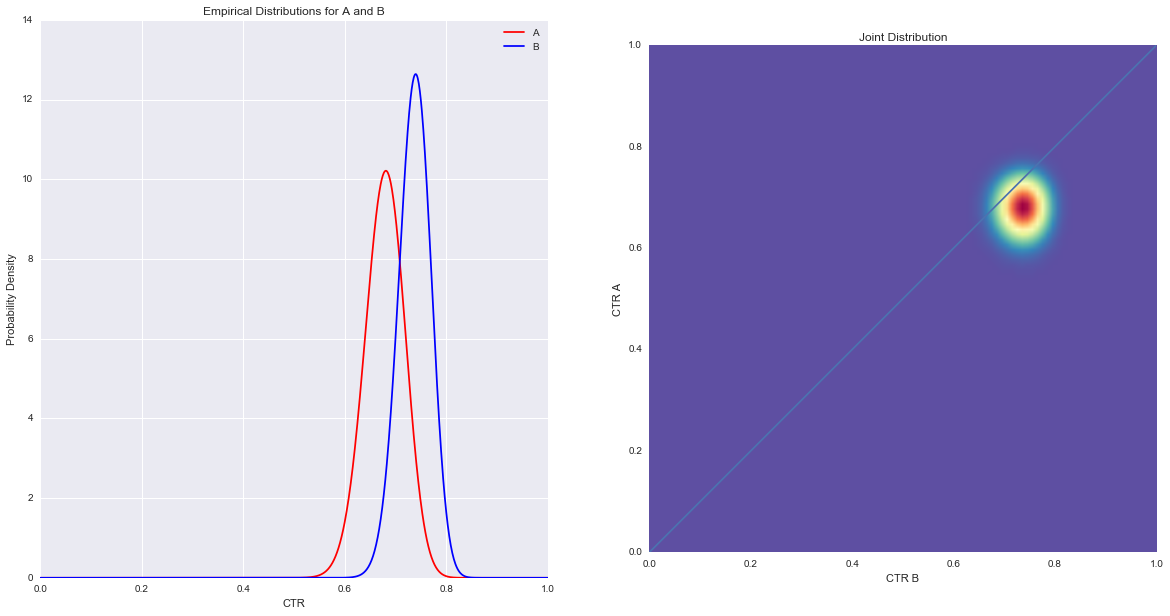

There is a 88% chance that B beats A


In [226]:
w=widgets.interactive(run,impressions_a=slider_imp_a,clicks_a=slider_clicks_a,impressions_b=slider_imp_b,clicks_b=slider_clicks_b)
display(w)

## References

https://web.archive.org/web/20150419163005/http://www.bayesianwitch.com/blog/2014/bayesian_ab_test.html

http://www.evanmiller.org/bayesian-ab-testing.html

In [223]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')